In [1]:
# This notebook implements the Logistic Regression model from scratch and uses it to make predictions on Admission Data

In [2]:
# Import Statements
import numpy as np
from pathlib import Path
import sklearn
import matplotlib.pyplot as plt

In [3]:
# Load the data into a numpy array
root = Path('archive')
filename = 'Admission_Predict_Ver1.1.csv'

admission_data = np.genfromtxt(root / filename, delimiter = ',')
#print(admission_data.shape)
admission_data = admission_data[1:,1:]
print(admission_data.shape)

(500, 8)


In [4]:
# Separate the predictors and the targets
X = admission_data[:,:-1]
Y = admission_data[:,-1:]
X.shape, Y.shape

((500, 7), (500, 1))

In [5]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X.mean(axis=0),'\n', X.std(axis=0)) # 0 mean and 1 std

[ 1.82587279e-15  1.32249767e-15  8.39328607e-17  4.61852778e-16
 -9.76996262e-18 -5.66346969e-15 -2.51354493e-16] 
 [1. 1. 1. 1. 1. 1. 1.]


In [6]:
def binarizeValues(input_2D_list):
    '''This function binarizes the values in a 2D list. It rounds up any element > 0.5 upto 1 and rounds down any element < 0.5
    down to 0.'''
    output_2D_list = []
    for input_inner_list in input_2D_list:
        output_inner_list = []
        for item in input_inner_list:
            if item < 0.5:
                output_inner_list.append(0)
            else:
                output_inner_list.append(1)
        output_2D_list.append(output_inner_list)        
    return output_2D_list


In [7]:
# Binarize the target vector
Y = np.array(binarizeValues(Y.tolist()))
# Shuffle up the data
shuffled_indices = np.random.permutation(X.shape[0])
X_shuffled = np.c_[np.ones((X.shape[0],1)),X[shuffled_indices]] # Add a column of 1's for the bias.
Y_shuffled = Y[shuffled_indices]
# Prepare the train and test sets
X_train = X_shuffled[:400]
Y_train = Y_shuffled[:400]
X_test = X_shuffled[400:]
Y_test = Y_shuffled[400:]

print(X_train[:10])
print(Y_train[:10])

[[ 1.          1.19888185  1.44968975  0.77558214  1.64240413  1.09894429
   1.44579426  0.88640526]
 [ 1.          0.66714832  0.46216267 -0.09979274  0.12727117  0.01730621
   0.76721964  0.88640526]
 [ 1.          0.66714832  0.79133837  1.65095702  1.64240413  1.63976333
   0.83342204  0.88640526]
 [ 1.         -1.10529675 -0.52536441 -0.09979274 -0.88281747 -1.60515091
  -0.75543561 -1.12815215]
 [ 1.          0.57852607 -0.52536441 -0.09979274  0.63231549  0.55812525
  -0.22581639  0.88640526]
 [ 1.         -0.0418297   0.29757483  0.77558214  1.13735981  0.01730621
   0.30380282  0.88640526]
 [ 1.         -1.63703027 -1.51289149 -0.97516761  0.63231549 -0.52351283
  -0.90439101 -1.12815215]
 [ 1.          0.31265931  0.46216267  1.65095702  1.64240413  1.63976333
   1.03202924  0.88640526]
 [ 1.          1.02163734  1.28510191  0.77558214  1.13735981  0.55812525
   0.96582684  0.88640526]
 [ 1.         -1.10529675 -0.68995225  1.65095702  1.64240413  0.55812525
   0.10519562 -1.

In [8]:
def Sigmoid(x):
    return 1/(1+ np.exp(-x))

Sigmoid(np.array([[-10, -5, 0],[0, 5, 10]]).dot(np.ones([3,1]))) # Testing the function execution

array([[3.05902227e-07],
       [9.99999694e-01]])

In [9]:
def CostFunction(X,Y,theta):
    m = X.shape[0]
    Y_predicted = Sigmoid(X.dot(theta))
    
    J = 0
    for i in range(m):
        J += Y[i]*np.log(Y_predicted[i]) + (1-Y[i])*np.log(1-Y_predicted[i])
    J = (-1/m)*J
    
    #J = (-1/m)*(np.dot(Y.T,np.log(Y_predicted)) + np.dot((1-Y).T,np.log(1-Y_predicted)))
    
    return J

def Gradients(X,Y,theta):
    m = X.shape[0]
    gradients = np.zeros(theta.shape)
    
    if m == 1:
        gradients = X.T.dot(Sigmoid(np.dot(X,theta))-Y) # Check if correct. Didn't have the sigmoid call, only argument before
    else:
        for j in range(len(theta)):   
            for i in range(m):
                gradients[j] += (Sigmoid(X[i].dot(theta)) - Y[i])*X[i,j]
            gradients[j] = (1/m)*gradients[j]
      
    #gradients = (1/m)*X.T.dot(Sigmoid(X.dot(theta)) - Y)
    
    return gradients

# Testing the function executions
print('Cost: ', '\n', CostFunction(np.array([[1,1],[1,1]]), np.array([[0],[0]]), np.array([[-5],[-5]])), '\n')
print('Gradient: ','\n', Gradients(np.array([[1,1],[1,1]]), np.array([[0],[0]]), np.array([[-5],[-5]])))

Cost:  
 [4.53988992e-05] 

Gradient:  
 [[4.53978687e-05]
 [4.53978687e-05]]


In [10]:
def BatchGradientDescent(X_train,Y_train,max_iters = 40000 ,alpha = 0.01, tolerance = 0.000001):
    m = len(X_train)
    theta = np.zeros((X_train.shape[1],1))
    previous_step_size = 1
    iteration = 0
    cost_history = []
    
    while previous_step_size > tolerance and iteration < max_iters:
        cost = CostFunction(X_train,Y_train,theta)
        cost_history.append(cost)
        theta_previous = theta #Store current x value in prev_x
        
        theta = theta - (alpha/m) * Gradients(X_train,Y_train,theta_previous) #Grad descent
        
        previous_step_size = np.linalg.norm((theta - theta_previous)) #Change in x
        iteration += 1 #iteration counter
    
    print("The local minimum occurs at:",'\n', theta, 'at',iteration,'iterations')    

    return theta, cost_history

In [11]:
def learning_schedule(t, t0, t1):
    return t0/(t + t1)
def StochasticGradientDescent(X_train, Y_train, epochs = 500, alpha = 0.1, tolerance = 0.000001, batch_size = 1): # If batch_size > 1, it becomes Mini-Batch Gradient Descent
    m = len(X_train)
    theta = np.zeros((X_train.shape[1],1))
    previous_step_size = 1
    cost_history = []
    epoch = 0
    
    while epoch < epochs and previous_step_size > tolerance:
        shuffled_indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[shuffled_indices]
        Y_train_shuffled = Y_train[shuffled_indices]

        for index in range(m):
            cost = CostFunction(X_train, Y_train, theta)
            cost_history.append(cost)
            
            previous_theta = theta
            alpha = learning_schedule(alpha,1,10)
            theta = theta - (alpha/m)*Gradients(np.array(X_train_shuffled)[index:index+batch_size,:],np.array(Y_train_shuffled)[index:index+batch_size,:],previous_theta)
            previous_step_size = np.linalg.norm((theta - previous_theta))
            
        epoch += 1
        
    print("The local minimum occurs at:",'\n', theta, 'at',epoch,'epochs')    

    return theta, cost_history

In [12]:
def MiniBatchGradientDescent(X_train, Y_train, epochs = 5000, alpha = 0.1, tolerance = 0.000001, batch_size = 10): # If batch_size > 1, it becomes Mini-Batch Gradient Descent
    m = len(X_train)
    theta = np.zeros((X_train.shape[1],1))
    previous_step_size = 1
    cost_history = []
    epoch = 0
    
    while epoch < epochs and previous_step_size > tolerance:
        shuffled_indices = np.random.permutation(len(X_train))
        X_train_shuffled = X_train[shuffled_indices]
        Y_train_shuffled = Y_train[shuffled_indices]

        
        cost = CostFunction(X_train, Y_train, theta)
        cost_history.append(cost)
            
        previous_theta = theta
        alpha = learning_schedule(alpha,1,10)
        theta = theta - (alpha/m)*Gradients(np.array(X_train_shuffled)[0:batch_size,:],np.array(Y_train_shuffled)[0:batch_size,:],previous_theta)
        previous_step_size = np.linalg.norm((theta - previous_theta))
            
        epoch += 1
        
    print("The local minimum occurs at:",'\n', theta, 'at',epoch,'epochs')    

    return theta, cost_history

In [33]:
strategy = ['BGD', 'SGD', 'MBGD'][2]
if strategy == 'BGD':
    theta_final, cost_history = BatchGradientDescent(X_train,Y_train) 
    # Accuracy: 0.93, Confusion Matrix: [[ 4  2],[ 5 89]]
elif strategy == 'SGD':
    theta_final, cost_history = StochasticGradientDescent(X_train,Y_train, batch_size = 1) 
    #  Batch Size = 1: Accuracy: 0.92, Confusion Matrix: [[ 0  8],[ 0 92]]
elif strategy == 'MBGD':
    theta_final, cost_history = MiniBatchGradientDescent(X_train,Y_train, batch_size = 10) 
    # Batch Size = 10: Accuracy: 0.93, Confusion Matrix: [[1  7],[0 92]]
    

The local minimum occurs at: 
 [[0.45056859]
 [0.0808237 ]
 [0.08051854]
 [0.03963138]
 [0.02177472]
 [0.05333966]
 [0.08323247]
 [0.04634312]] at 5000 epochs


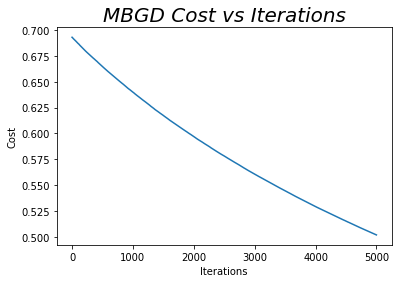

In [34]:

plt.plot(np.arange(len(cost_history)), cost_history)
plt.title('{} Cost vs Iterations'.format(strategy),fontsize=20,fontstyle='italic')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.savefig('{}_CostVsIterations.png'.format(strategy), dpi = 300)
plt.show()


In [35]:
# Obtain the predictions for the test data, given the trained parameters
def predictTestData(X_test,theta):
    predictions = Sigmoid(X_test.dot(theta))
    return predictions

Y_test_predictions = predictTestData(X_test, theta_final)
Y_test_predictions[:20]

array([[0.65583842],
       [0.57496609],
       [0.58255479],
       [0.53537159],
       [0.67853891],
       [0.68499994],
       [0.68682902],
       [0.66335742],
       [0.64736369],
       [0.66520721],
       [0.58928077],
       [0.66051459],
       [0.74878143],
       [0.62344238],
       [0.59291897],
       [0.71059253],
       [0.62314438],
       [0.5625028 ],
       [0.54448584],
       [0.558504  ]])

In [36]:
# Convert the predicted target values into 0's and 1's
Y_test_predictions = np.array(binarizeValues(Y_test_predictions.tolist()))

In [37]:
def performanceMetrics(l1,l2):
    '''This function compares two lists element-wise and returns accuracy, confusion matrix, precision, recall and f1-score'''
    # l1: Actual labels
    # l2: Predicted labels
    TN,FP,FN,TP = [0]*4
    
    for item1,item2 in zip(l1,l2):
        if item1 == item2:
            if item1 == 0:
                TN += 1
            elif item1 == 1:
                TP += 1
        else:
            if item1 == 0 and item2 == 1:
                FP += 1
            elif item1 == 1 and item2 == 0:
                FN += 1
    accuracy = (TN + TP)/(TN + FP + FN + TP)
    confusion_matrix = np.array([[TN, FP],[FN, TP]])
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    f1_score = TP/(TP + (FN + FP)/2)
    return accuracy, confusion_matrix, precision, recall, f1_score

accuracy, confusion_matrix, precision, recall, f1_score = performanceMetrics(Y_test.flatten().tolist(),Y_test_predictions.flatten().tolist())
print('Test Set Accuracy: {}'.format(accuracy))
print('Confusion Matrix : ', '\n', '{}'.format(confusion_matrix))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F1-score: {}'.format(f1_score))

Test Set Accuracy: 0.91
Confusion Matrix :  
 [[ 3  3]
 [ 6 88]]
Precision: 0.967032967032967
Recall: 0.9361702127659575
F1-score: 0.9513513513513514
